Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [3]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns

%matplotlib inline

In [4]:
data = pd.read_csv(r'C:\Users\af.sabirova\Desktop\pyda\3 модуль ДЗ\3.4\2\aac_shelter_outcomes.csv')
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [5]:
#age_upon_outcome - возраст животного на момент ухода из приюта
#animal_id 
#animal_type - Вид животного: кошка, собака и др. 
#breed - порода животных. Многие животные являются общими смешанными породами, например "Long-haired mix"
#color - цвет шерсти, если имеется
#date_of_birth - дата рождения 
#datetime - временная метка результата
#monthyear
#name - Кличка
#outcome_subtype - подтип результата
#outcome_type - Конечное решение по животному (передан, усыплен, принят)
#sex upon outcome - пол

Посмотрим отсутствующие значения

,Total,Percent
outcome_subtype,42293,54.044418
name,23886,30.522899
outcome_type,12,0.015334
age_upon_outcome,8,0.010223
sex_upon_outcome,2,0.002556


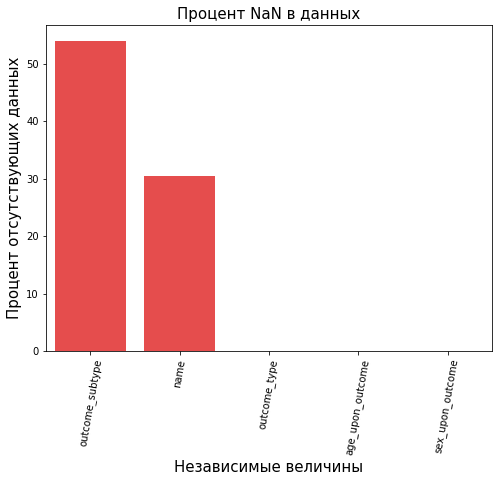

In [6]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms


missingdata(data)

In [42]:
import pandas_profiling

In [6]:
#data.profile_report()

Начнем анализ со столбца возраст питомца на момент ухода из приюта. Отсутствующих значений меньше 0,1%, поэтому эти данные можно удалить без большой потери данных. 

In [7]:
data= data.dropna(subset=['age_upon_outcome'])

In [8]:
data['age_upon_outcome'].isnull().sum()

0

In [9]:
data['age_upon_outcome'].unique()

array(['2 weeks', '1 year', '9 years', '5 months', '4 months', '3 years',
       '1 month', '3 months', '2 years', '2 months', '4 years', '8 years',
       '3 weeks', '8 months', '12 years', '7 years', '5 years', '6 years',
       '5 days', '10 months', '4 weeks', '10 years', '2 days', '6 months',
       '14 years', '11 months', '15 years', '7 months', '13 years',
       '11 years', '16 years', '9 months', '3 days', '6 days', '4 days',
       '5 weeks', '1 week', '1 day', '1 weeks', '0 years', '17 years',
       '20 years', '18 years', '19 years', '22 years', '25 years'],
      dtype=object)

Для удобства анализа, мне кажется, будет лучше если мы переведем данные в числовые значения, для этого поделим на 2 столбца: числовую и текстовую информацю

In [10]:
data['age_1']=data['age_upon_outcome'].str[2:]
data['age_2']=data['age_upon_outcome'].str[:2].astype(int)

In [11]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_1,age_2
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,weeks,2
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,year,1
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,year,1
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,years,9
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,months,5


In [12]:
data['age_1'].unique()

array(['weeks', 'year', 'years', 'months', 'month', ' years', 'days',
       ' months', 'week', 'day'], dtype=object)

In [13]:
data['age_2'].unique()

array([ 2,  1,  9,  5,  4,  3,  8, 12,  7,  6, 10, 14, 11, 15, 13, 16,  0,
       17, 20, 18, 19, 22, 25], dtype=int64)

Так как уникальных значений по age_1 не так уж и много, переведем все в дни в дни (1 день), недели (7 дней), год (365 дней)

In [14]:
def age_cat(a):
    if a =='weeks':
        return '7'
    if a =='year':
        return '365'
    if a =='years':
        return '365'
    if a =='months':
        return '30'
    if a =='month':
        return '30'
    if a ==' years':
        return '365'
    if a =='days':
        return '1'
    if a ==' months':
        return '30'
    if a =='week':
        return '7'
    if a =='day':
        return '1'

In [15]:
data['age_days']=data.age_1.apply(age_cat).astype(int)
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_1,age_2,age_days
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,weeks,2,7
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,year,1,365
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,year,1,365
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,years,9,365
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,months,5,30


In [16]:
data['age_days'].unique()

array([  7, 365,  30,   1], dtype=int64)

Теперь перемножим age_days и age_2 и получим возраст питомцов в днях. 

In [17]:
data['age_pets']=data['age_days']*data['age_2']
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_1,age_2,age_days,age_pets
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,weeks,2,7,14
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,year,1,365,365
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,year,1,365,365
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,years,9,365,3285
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,months,5,30,150


Теперь мы можем удалить лишние столбцы:

age_upon_outcome

date_of_birth

datetime

monthyear (полностью дублирует столбец datetime, поэтому не несет поезную информацию)

age_1

age_2	

age_days	

In [18]:
data = data.drop(['age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'age_1', 'age_2', 'age_days'], axis=1)
data.head()

,animal_id,animal_type,breed,color,name,outcome_subtype,outcome_type,sex_upon_outcome,age_pets
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,NaN,Partner,Transfer,Intact Male,14
1,A666430,Dog,Beagle Mix,White/Brown,Lucy,Partner,Transfer,Spayed Female,365
2,A675708,Dog,Pit Bull,Blue/White,*Johnny,NaN,Adoption,Neutered Male,365
3,A680386,Dog,Miniature Schnauzer Mix,White,Monday,Partner,Transfer,Neutered Male,3285
4,A683115,Other,Bat Mix,Brown,NaN,Rabies Risk,Euthanasia,Unknown,150


В столбце name содержатся очень много уникальных значений, поэтому переводить его в "OHE" не имеет смысла, да и кличка по логике не должна влиять на нашу метку, поэтому этот столбец и animal_id нужно удалить. 

In [19]:
data = data.drop(['animal_id', 'name'], axis=1)
data.head()

,animal_type,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,age_pets
0,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,14
1,Dog,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,365
2,Dog,Pit Bull,Blue/White,NaN,Adoption,Neutered Male,365
3,Dog,Miniature Schnauzer Mix,White,Partner,Transfer,Neutered Male,3285
4,Other,Bat Mix,Brown,Rabies Risk,Euthanasia,Unknown,150


In [20]:
data.shape

(78248, 7)

Проанализируем нашу целевую метрику. Он содержит 9 уникальных классов, нам для предсказания нужны только 2 класса: 'Adoption' и 'Transfer', поэтому создадим новую таблицу с необходимыми данными. 

In [21]:
data = data[ (data['outcome_type']=='Transfer')| (data['outcome_type']=='Adoption') ]
data.head()

,animal_type,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,age_pets
0,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,14
1,Dog,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,365
2,Dog,Pit Bull,Blue/White,NaN,Adoption,Neutered Male,365
3,Dog,Miniature Schnauzer Mix,White,Partner,Transfer,Neutered Male,3285
5,Dog,Leonberger Mix,Brown/White,Partner,Transfer,Intact Male,120


In [22]:
data.shape

(56609, 7)

In [23]:
#data.profile_report()

In [24]:
print(data.isnull().sum())

animal_type             0
breed                   0
color                   0
outcome_subtype     27186
outcome_type            0
sex_upon_outcome        0
age_pets                0
dtype: int64


Удалим столбец outcome_subtype, так как содержит около 48% пропусков

In [25]:
data = data.drop(['outcome_subtype'], axis=1)
data.head()

,animal_type,breed,color,outcome_type,sex_upon_outcome,age_pets
0,Cat,Domestic Shorthair Mix,Orange Tabby,Transfer,Intact Male,14
1,Dog,Beagle Mix,White/Brown,Transfer,Spayed Female,365
2,Dog,Pit Bull,Blue/White,Adoption,Neutered Male,365
3,Dog,Miniature Schnauzer Mix,White,Transfer,Neutered Male,3285
5,Dog,Leonberger Mix,Brown/White,Transfer,Intact Male,120


In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def get_mix(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'mix'
    return x
data['Mix'] = data.breed.apply(get_mix)
data.head()

,animal_type,breed,color,outcome_type,sex_upon_outcome,age_pets,Mix
0,Cat,Domestic Shorthair Mix,Orange Tabby,Transfer,Intact Male,14,mix
1,Dog,Beagle Mix,White/Brown,Transfer,Spayed Female,365,mix
2,Dog,Pit Bull,Blue/White,Adoption,Neutered Male,365,Pit Bull
3,Dog,Miniature Schnauzer Mix,White,Transfer,Neutered Male,3285,mix
5,Dog,Leonberger Mix,Brown/White,Transfer,Intact Male,120,mix


Даже после группировки всех смешанных пород в единую порожду, количество уникальных значений сократилось до 1499, что тоже очень много. Следующим этапом попробуем заменить значения ячеек с содержанием / так же на микс.

In [45]:
def get_mix(x):
    x = str(x)
    if x.find('/') >= 0: return 'mix'
    return x
data['Mix_1'] = data.Mix.apply(get_mix)
data.head()

,animal_type,breed,color,outcome_type,sex_upon_outcome,age_pets,Mix,Mix_1
0,Cat,Domestic Shorthair Mix,Orange Tabby,Transfer,Intact Male,14,mix,mix
1,Dog,Beagle Mix,White/Brown,Transfer,Spayed Female,365,mix,mix
2,Dog,Pit Bull,Blue/White,Adoption,Neutered Male,365,Pit Bull,Pit Bull
3,Dog,Miniature Schnauzer Mix,White,Transfer,Neutered Male,3285,mix,mix
5,Dog,Leonberger Mix,Brown/White,Transfer,Intact Male,120,mix,mix


После этой операции, количество уникальных значений по Mix_1 осталось 195. Оставим пока так. 

In [50]:
data = data.drop(['breed', 'Mix'], axis=1)
data.head()

,animal_type,color,outcome_type,sex_upon_outcome,age_pets,Mix_1
0,Cat,Orange Tabby,Transfer,Intact Male,14,mix
1,Dog,White/Brown,Transfer,Spayed Female,365,mix
2,Dog,Blue/White,Adoption,Neutered Male,365,Pit Bull
3,Dog,White,Transfer,Neutered Male,3285,mix
5,Dog,Brown/White,Transfer,Intact Male,120,mix


In [74]:
len((data['color']).unique())

475

Следующим шагом попробуем уменьшить количество признаков по цвету. Также заменим цвета с / на микс. 

In [76]:
def get_color(x):
    x = str(x)
    if x.find('/') >= 0: return 'mix'

    return x
data['color_new'] = data.color.apply(get_color)
data.head()

,animal_type,color,outcome_type,sex_upon_outcome,age_pets,Mix_1,color_new
0,Cat,Orange Tabby,Transfer,Intact Male,14,mix,Orange Tabby
1,Dog,White/Brown,Transfer,Spayed Female,365,mix,mix
2,Dog,Blue/White,Adoption,Neutered Male,365,Pit Bull,mix
3,Dog,White,Transfer,Neutered Male,3285,mix,White
5,Dog,Brown/White,Transfer,Intact Male,120,mix,mix


In [78]:
len((data['color_new']).unique())

56

In [92]:
data = data.drop(['color'], axis=1)
data.head()

,animal_type,outcome_type,sex_upon_outcome,age_pets,Mix_1,color_new
0,Cat,Transfer,Intact Male,14,mix,Orange Tabby
1,Dog,Transfer,Spayed Female,365,mix,mix
2,Dog,Adoption,Neutered Male,365,Pit Bull,mix
3,Dog,Transfer,Neutered Male,3285,mix,White
5,Dog,Transfer,Intact Male,120,mix,mix


In [46]:
data.profile_report()

Обработаем категориальные признаки 	animal_type; breed; color; sex_upon_outcome с помощью OHE

In [93]:
animal_type = data['animal_type'].get_values().reshape(-1,1)
breed = data['Mix_1'].get_values().reshape(-1,1)
color = data['color_new'].get_values().reshape(-1,1)
sex_upon_outcome = data['sex_upon_outcome'].get_values().reshape(-1,1)

In [94]:
from sklearn import preprocessing
oh_encoder = preprocessing.OneHotEncoder() 
oh_encoder.fit(animal_type)
oh_result = oh_encoder.transform(animal_type).toarray()
oh_result

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [95]:
oh_encoder1 = preprocessing.OneHotEncoder() 
oh_encoder1.fit(breed)
oh_result1 = oh_encoder1.transform(breed).toarray()
oh_result1

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [96]:
oh_encoder2 = preprocessing.OneHotEncoder() 
oh_encoder2.fit(color)
oh_result2 = oh_encoder2.transform(color).toarray()
oh_result2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [97]:
oh_encoder3 = preprocessing.OneHotEncoder() 
oh_encoder3.fit(sex_upon_outcome)
oh_result3 = oh_encoder3.transform(sex_upon_outcome).toarray()
oh_result3

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [98]:
animal_type_columns=['animal_type_{}'.format (i) for i in range (oh_result.shape[1])]
animal_type_data = pd.DataFrame(oh_result, columns = animal_type_columns)
animal_type_data.index = data.index
data_animal = pd.concat([data, animal_type_data], axis = 1)
data_animal = data_animal.drop(['animal_type'],axis=1)
data_animal.head()

,outcome_type,sex_upon_outcome,age_pets,Mix_1,color_new,animal_type_0,animal_type_1,animal_type_2,animal_type_3,animal_type_4
0,Transfer,Intact Male,14,mix,Orange Tabby,0.0,1.0,0.0,0.0,0.0
1,Transfer,Spayed Female,365,mix,mix,0.0,0.0,1.0,0.0,0.0
2,Adoption,Neutered Male,365,Pit Bull,mix,0.0,0.0,1.0,0.0,0.0
3,Transfer,Neutered Male,3285,mix,White,0.0,0.0,1.0,0.0,0.0
5,Transfer,Intact Male,120,mix,mix,0.0,0.0,1.0,0.0,0.0


In [112]:
breed_columns=['breed_{}'.format (i) for i in range (oh_result1.shape[1])]
breed_data = pd.DataFrame(oh_result1, columns = breed_columns)
breed_data.index = data.index
data_breed = pd.concat([data_animal, breed_data], axis = 1)
data_breed = data_breed.drop(['Mix_1'],axis=1)
data_breed.head()

,outcome_type,sex_upon_outcome,age_pets,color_new,animal_type_0,animal_type_1,animal_type_2,animal_type_3,animal_type_4,breed_0,...,breed_185,breed_186,breed_187,breed_188,breed_189,breed_190,breed_191,breed_192,breed_193,breed_194
0,Transfer,Intact Male,14,Orange Tabby,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Transfer,Spayed Female,365,mix,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Adoption,Neutered Male,365,mix,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Transfer,Neutered Male,3285,White,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,Transfer,Intact Male,120,mix,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [113]:
color_columns=['color_{}'.format (i) for i in range (oh_result2.shape[1])]
color_data = pd.DataFrame(oh_result2, columns = color_columns)
color_data.index = data.index
data_color = pd.concat([data_breed, color_data], axis = 1)
data_color = data_color.drop(['color_new'],axis=1)
data_color.head()

,outcome_type,sex_upon_outcome,age_pets,animal_type_0,animal_type_1,animal_type_2,animal_type_3,animal_type_4,breed_0,breed_1,...,color_46,color_47,color_48,color_49,color_50,color_51,color_52,color_53,color_54,color_55
0,Transfer,Intact Male,14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Transfer,Spayed Female,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Adoption,Neutered Male,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Transfer,Neutered Male,3285,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,Transfer,Intact Male,120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [114]:
sex_upon_outcome_columns=['sex_upon_outcome_{}'.format (i) for i in range (oh_result3.shape[1])]
sex_upon_outcome_data = pd.DataFrame(oh_result3, columns = sex_upon_outcome_columns)
sex_upon_outcome_data.index = data.index
data_new = pd.concat([data_color, sex_upon_outcome_data], axis = 1)
data_new = data_new.drop(['sex_upon_outcome'],axis=1)
data_new.head()

,outcome_type,age_pets,animal_type_0,animal_type_1,animal_type_2,animal_type_3,animal_type_4,breed_0,breed_1,breed_2,...,color_51,color_52,color_53,color_54,color_55,sex_upon_outcome_0,sex_upon_outcome_1,sex_upon_outcome_2,sex_upon_outcome_3,sex_upon_outcome_4
0,Transfer,14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Transfer,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Adoption,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,Transfer,3285,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,Transfer,120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Слeдующим шагом переведем целевую метрику в числовые показатели. 

In [115]:
data_new['outcome'] = data_new['outcome_type']
data_new.loc[data['outcome_type'] == 'Transfer', 'outcome'] = 0
data_new.loc[data['outcome_type'] == 'Adoption', 'outcome'] = 1
data_new = data_new.drop(['outcome_type'], axis=1)
data_new.head()

,age_pets,animal_type_0,animal_type_1,animal_type_2,animal_type_3,animal_type_4,breed_0,breed_1,breed_2,breed_3,...,color_52,color_53,color_54,color_55,sex_upon_outcome_0,sex_upon_outcome_1,sex_upon_outcome_2,sex_upon_outcome_3,sex_upon_outcome_4,outcome
0,14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,3285,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
5,120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0


Обработку данных можно считать законченной и перейти к построению логистической регресии.

In [104]:
from sklearn.linear_model import LogisticRegression

y = data_new.outcome
X = data_new.drop('outcome', axis=1)

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [106]:
from sklearn.metrics import classification_report

# разделим на тренировочные данные и на тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)


model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.90      0.62      0.73      5799
           1       0.78      0.95      0.86      8354

    accuracy                           0.81     14153
   macro avg       0.84      0.79      0.80     14153
weighted avg       0.83      0.81      0.81     14153



In [121]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(max_depth = 10, min_samples_split=2, n_estimators = 100, random_state = 1)
my_forest = forest.fit(X_train, y_train)

y_pred_my_forest = my_forest.predict(X_test)

print(classification_report(y_test, y_pred_my_forest))

              precision    recall  f1-score   support

           0       0.93      0.26      0.40      5799
           1       0.66      0.99      0.79      8354

    accuracy                           0.69     14153
   macro avg       0.79      0.62      0.60     14153
weighted avg       0.77      0.69      0.63     14153



Вывод: дерево решений не дало улучшений результатов по R2. Скорее всего модель дает низкий результат R2б в связи с большим количеством столбцов. Попробуем построить модель без пола, посмотрим даст ли это улучшение

In [116]:
data_color['outcome'] = data_color['outcome_type']
data_color.loc[data_color['outcome_type'] == 'Transfer', 'outcome'] = 0
data_color.loc[data_color['outcome_type'] == 'Adoption', 'outcome'] = 1
data_color = data_color.drop(['outcome_type'], axis=1)
data_color.head()

,sex_upon_outcome,age_pets,animal_type_0,animal_type_1,animal_type_2,animal_type_3,animal_type_4,breed_0,breed_1,breed_2,...,color_47,color_48,color_49,color_50,color_51,color_52,color_53,color_54,color_55,outcome
0,Intact Male,14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Spayed Female,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,Neutered Male,365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,Neutered Male,3285,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5,Intact Male,120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [117]:
data_color = data_color.drop(['sex_upon_outcome'], axis=1)

In [118]:
y = data_color.outcome
X = data_color.drop('outcome', axis=1)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)


model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.54      0.35      0.42      5799
           1       0.64      0.79      0.71      8354

    accuracy                           0.61     14153
   macro avg       0.59      0.57      0.57     14153
weighted avg       0.60      0.61      0.59     14153



Удалив цвет шерсти и пол, точность предсказания модели сильно снизилась. 
Вывод: логистическая модель построеная ранее была наиболее точной. 